# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

# Lab 05 probabilistic noise suppression methods
2023/04/14

- attached: 
    1. [`lab05.pdf`](lab05.pdf)
    1. [`lab05.md`](lab05.md)

----
# import packages, define analysis parameters and draw parameters, audio file preparation, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

---
### load speech and noise

오디오 파일들의 경로 정의

In [5]:
audioinputpath = '../audio'
outpath = 'out'

# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

In [6]:
speechfile = addpath(audioinputpath, 'gjang-kdigits0-3.wav')
noisefile  = addpath(audioinputpath, 'car.wav')
wnoisefile  = addpath(audioinputpath, 'car_wideband.wav')   # 넓은 주파수 대역에 분포한 잡음

__load files in windows wav format__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [7]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono='True')
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
wnoise, _ = librosa.load(wnoisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speechfile, speech.shape, speech)
print(noisefile, noise.shape, noise)
print(wnoisefile, wnoise.shape, wnoise)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

../audio/gjang-kdigits0-3.wav (37952,) [-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04]
../audio/car.wav (175745,) [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
../audio/car_wideband.wav (175745,) [-0.05984497 -0.14807129 -0.14700317 ... -0.10241699 -0.10253906
 -0.09594727]
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


array([[  3.43608106,   6.52668654,   6.4201852 , ...,  -3.22208712,
        -12.109726  ,  -4.36789082],
       [ 16.55197942,  18.74696753,  18.31199222, ...,  19.0139984 ,
         19.83277802,  20.39343026],
       [ 17.40766666,  20.26121289,  22.16222055, ...,  23.42829917,
         24.75091936,  23.02823122],
       ...,
       [-38.4390941 , -34.7011153 , -44.66451486, ..., -43.87783998,
        -66.51596708, -37.96959437],
       [-39.0657465 , -35.03712344, -45.91154493, ..., -44.16382711,
        -67.00779024, -38.02013985],
       [-38.56792469, -34.81379091, -44.87832819, ..., -43.44395922,
        -78.27134367, -38.10852218]])

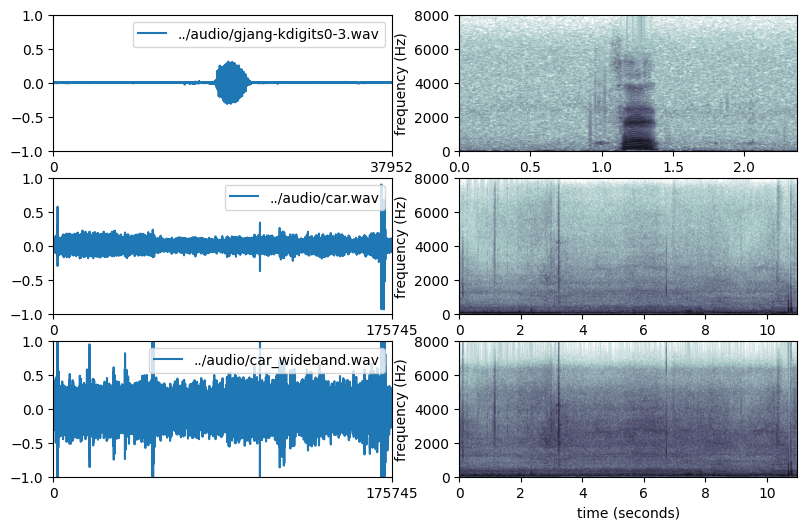

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.2,2.0]))

def plotsignal(s, lab):
    plt.plot(s, label=lab)
    plt.xlim(0,len(s)); plt.ylim(-1,1)
    plt.xticks([0, len(s)])
    plt.legend(loc='upper right')

plt.subplot(3,2,1)
plotsignal(speech, speechfile)
plt.subplot(3,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

plt.subplot(3,2,3)
plotsignal(noise, noisefile)
plt.subplot(3,2,4)
drawspectrogram3(noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

plt.subplot(3,2,5)
plotsignal(wnoise, wnoisefile)
plt.subplot(3,2,6)
drawspectrogram3(wnoise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

In [9]:
IPython.display.Audio(speechfile)

In [10]:
IPython.display.Audio(noisefile)

In [11]:
IPython.display.Audio(wnoisefile)

__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.
- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

In [12]:
def generate_mixed_signals(speech, noise, SNRs, isdraw=False):
    std_s = np.sqrt(np.mean(speech**2))
    std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
    mixedSig = []
    for snr in mixsnrs:
        gain = np.power(10, -snr/20)
        gn = noise[:len(speech)]/std_n*std_s*gain
        m = speech + gn
        mixedSig.append(m)
        print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR=%.2f' % (snr, gain,10*np.log10(np.sum(speech**2)/np.sum(gn**2))))

        # draw
        if isdraw:
            plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
            plt.subplot(1,2,1)
            xscale = np.arange(len(gn))/Fs
            plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
            plt.title('SNR = %.0f dB' % (snr))
            plt.subplot(1,2,2)
            drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

    return mixedSig

In [13]:
mixsnrs = np.array([20, 10, 0, -10])
mixedSig1 = generate_mixed_signals(speech, noise, mixsnrs, False)
mixedSig2 = generate_mixed_signals(speech, wnoise, mixsnrs, False)

Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00
Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00


---
# Programming assignments: implementating probabilistic noise suppression methods

---
## 1. probabilstic voice activity detection (VAD) for noise spectrum estimation
- fixed thresholding 으로 noise 구간을 구하면 noise 의 크기에 크게 
    영향받을 수 밖에 없다. 따라서 noise 구간을 유연하게 추정할 수 있는
    (adaptive thresholding) 확률 모델을 사용하여 본다.

1. 확률 모델을 이용하여 probabilistic voice activity detection 수행
2. 각 frame 별로 noise 확률 계산 - find P(voice|y), y 는 한 frame 
3. (deterministic decision) 확률값을 thresholding 하여 binary classification, 그리고 검출된 noise frame 들의 평균 제곱 Fourier 성분으로 noise spectrum 예측 
4. (soft decision and maximum a posteriori estimation) 각 frame 별로 posterior probability ( P( voice | y ) ) 를 계산함. 그리고 noise spectrum 을 posterior probability로 weighted estimation 한다.  E[N] = sum (1-P(v|y)) y
5. 두 가지 방법(deterministic/soft)으로 추정한 noise spectrum 으로 suppression 한 결과 비교 
6. noise 차감은 lab04 의 time-domain Wiener filtering 이용

---
## 2. time domain VAD

1. time domain signal 에 대해서 dual Gaussian mixture model 을 이용하여 probabilistic voice activity detection 
2. speech 의 크기가 noise 의 크기보다 작다고 가정하고 
작은 Gaussian 을 noise 분포로 가정 
3. P(noise|y) = p(noise) p(y|noise), y 는 한 frame

### Speech and noise distribution
- raw signal 자체의 확률 분포 $p(x)$, $p(n)$ 를 그려본다. 

In [14]:
# 확률 분포를 relative histogram 으로 그린다.
def plot_relative_hist(x, bins=10, lab=''):
    # plt.hist(x, bins=50)   # 개수를 보여준다. 확률은 아래와 같이 
    counts, bins = np.histogram(x, bins=bins)
    fcounts = counts / len(x)
    plt.stairs(fcounts, bins, label=lab)
    return fcounts

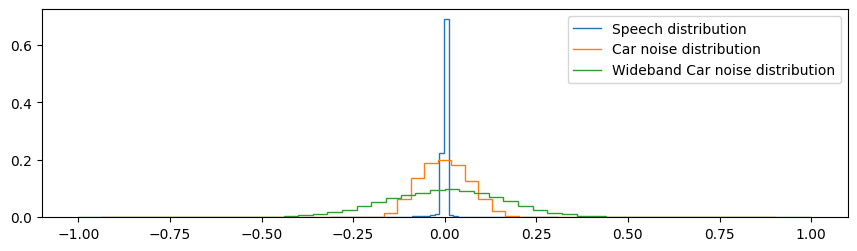

In [15]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
plot_relative_hist(speech, bins=50, lab='Speech distribution')
plot_relative_hist(noise, bins=50, lab='Car noise distribution')
plot_relative_hist(wnoise, bins=50, lab='Wideband Car noise distribution')
plt.legend(loc='upper right')

- 음성의 pdf $f_{x}(x)$ 는 매우 peaky 하고 long tail을 가진 Laplacian 을 따른다.
$$ f_{X} (y) = \frac{1}{\sqrt{2} \sigma_{X}} \exp \left[ - \sqrt{2} \frac{|y-\mu_{X}|}{\sigma_{X}} \right] $$

- noise pdf $f_{N} (n)$ 는 bell-shaped Gaussian distribution 을 따른다.
$$ f_{N} (y) = \frac{1}{\sqrt{2 \pi } \sigma_{N}} \exp \left[ - \frac{(y-\mu_{N})^{2}}{\sigma_{N}^2} \right] $$

- mixed signal 의 분포 $p(y=x+n)$ 도 그려보자
    - SNR 10, 0, -10 dB

Text(0.5, 1.0, '../audio/gjang-kdigits0-3.wav + ../audio/car_wideband.wav')

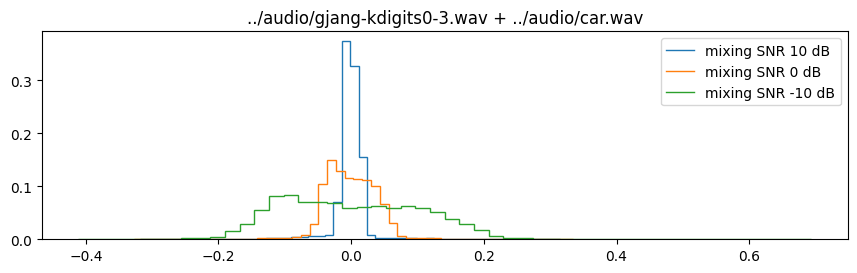

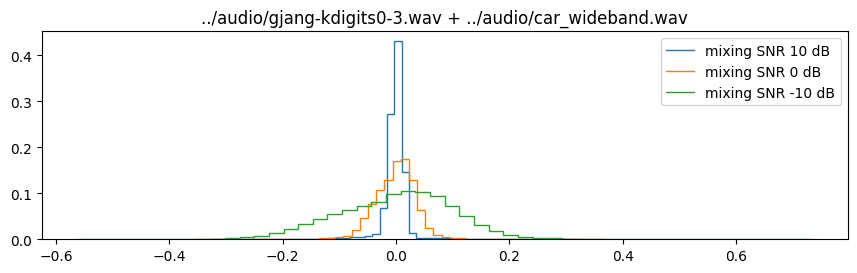

In [16]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
for i in range(1,4):
    plot_relative_hist(mixedSig1[i], bins=50, lab='mixing SNR %.0f dB'%(mixsnrs[i]))
plt.legend(loc='upper right')
plt.title(speechfile + ' + ' + noisefile)

plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
for i in range(1,4):
    plot_relative_hist(mixedSig2[i], bins=50, lab='mixing SNR %.0f dB'%(mixsnrs[i]))
plt.legend(loc='upper right')
plt.title(speechfile + ' + ' + wnoisefile)

- 두 개의 확률 변수의 합으로 이루어진 새로운 확률변수의 확률은 각각의 변수의 확률의 convolution (pdf에서도 성립함)
$$ Z = X + Y \quad \Rightarrow \quad P(Z=z) = \int_{-\infty}^{\infty} P(X=x) P(Y=z-x) dx = \int_{-\infty}^{\infty} P(X=z-y) P(Y=y) dy $$

- 따라서 $f_{Y}(y) = f_{X}(x) \ast f_{N} (n)$ 이 되어서 $n$의 값이 클수록 $f_{X}(x)$ 가 안 보이고 Gaussian 에 수렴한다.

---
### Speech and noise distribution in frame energy domain
- short time energy의 확률 분포를 그려보고 raw signal 분포와 비교한다.
$$ \mathrm{let} \, u[k] = \sqrt{\sum_{t \in \mathrm{frame} \, k} y^2(t)} $$
- draw $p_{X}(u)$ and $p_{N} (u)$

In [17]:
T = len(speech)
num_frames = (T-Nf)//Ns+1
ux, un, uwn = np.zeros(num_frames), np.zeros(num_frames), np.zeros(num_frames)
for k in range(num_frames):
    x = speech[(k*Ns):(k*Ns+Nf)]
    n = noise[(k*Ns):(k*Ns+Nf)]
    wn = wnoise[(k*Ns):(k*Ns+Nf)]
    
    ux[k] = np.sqrt(np.mean(x*x))
    un[k] = np.sqrt(np.mean(n*n))
    uwn[k] = np.sqrt(np.mean(wn*wn))

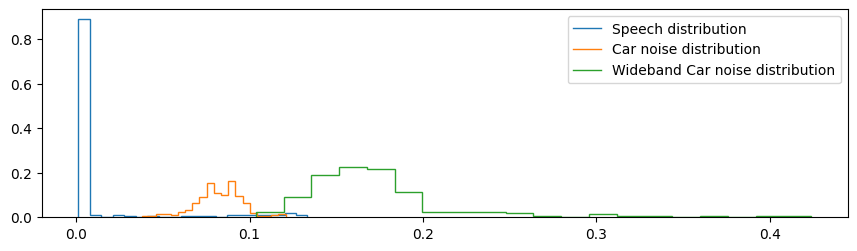

In [18]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
plot_relative_hist(ux, bins=20, lab='Speech distribution')
plot_relative_hist(un, bins=20, lab='Car noise distribution')
plot_relative_hist(uwn, bins=20, lab='Wideband Car noise distribution')
plt.legend(loc='upper right')

- frame energy 로 예측하면 sample distribution 과 매우 다르게 나타난다.
- $u_y[k]$ 를 dual Gaussian mixture model 로 예측한다.

---
### Dual Gaussian mixture model 

__공통적으로 사용되는 frame 을 하나씩 추출하는 class를 정의한다.__ 

__(그림)__

In [19]:
class FrameIterator:
    def __init__(self, T, frame_len, shift_len, mode=1):
        self.set(T, frame_len, shift_len, mode)
        
    def set(self, T, frame_len, shift_len, mode):
        self.Nf = frame_len
        self.Ns = shift_len
        self.frame = np.zeros(self.Nf)
        self.buf = np.zeros(self.Nf-self.Ns)
        self.update_num_frames(mode)
    
    def update_num_frames(self, mode):
        if mode == 1:
            self.num_frames = np.ceil(T/self.Ns).astype(int)   # including last frame (<Ns)
        elif mode == 2:
            self.num_frames = T//self.Ns   # not including last frame (<Ns)
        elif mode == 3:
            self.num_frames = (T-self.Nf)//self.Ns   # only complete frames (speech recognition)
        else:
            print('unknown mode: %d, changed to mode 2'%(mode))
            self.update_num_frames(2)
            
        self.mode = mode
        self.frameIdx = 0    # start from the first frame
        
    def reset(self):  # do not change any sizes, just set zero
        self.frame[:] = 0
        self.buf[:] = 0
    
    #######################################################
    # get one frame from the signal
    # returns frame, actual_frame_len, frame_center_index
    # frame_center_idx may be negative or larger than signal length
    # if Nf > 2*Ns
    def get(self, sig):
        if self.mode == 1 or self.mode == 2:
            t0 = self.frameIdx*self.Ns
            L = min(len(sig)-t0, self.Ns)   # how many samples available from the input
            if L != self.Ns: print(t0,L)
            Noverlap = self.Nf-self.Ns
            self.frame[:Noverlap] = self.buf[:]
            self.frame[Noverlap:(Noverlap+L)] = sig[t0:(t0+L)]
            if L != self.Ns: self.frame[(Noverlap+L):] = 0
            self.buf[:] = self.frame[-(Noverlap):]
            centerIdx = t0-Noverlap+self.Nf//2

        elif mode == 3:
            t0 = self.frameIdx*self.Ns
            L = self.Nf   # complete frames only
            self.frame[:] = sig[t0:(t0+L)]
            centerIdx = t0+self.Nf//2

        # to next frame
        self.frameIdx += 1   # frameIdx is the number of frames returned
        self.Nlast = L   # may be needed later

        return self.frame, L, centerIdx

frame energy 를 추출한다.

In [20]:
# function [E, CenterSampleIDX] = ShortTimeFrameEng(sig, frame_len, shift_len)
#  returns frame energies of frames shifted by shift_len
#  CenterSampleIDX is the location of the center of the frames (usually for drawing)
#    for sample, frame_len=320, shift_len=160
#    frame1 = [0 320], center1 = [160]
#    frame2 = [160 480], center1 = [320]
#    ...

def ShortTimeFrameEng(sig, frame_len, shift_len):
    it = FrameIterator(len(sig), frame_len, shift_len, mode=1)
    eng = np.zeros(it.num_frames)
    centeridx = np.zeros(it.num_frames, dtype=int)   # center sample indexes
    for k in range(it.num_frames):
        x, _, centeridx[k] = it.get(sig)
        eng[k] = np.mean(x*x)
    return eng, centeridx

In [21]:
# definition of (log) Gaussian pdf
'''
def normpdf(x, mu, variance):
    #return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sig**2))
    lp = -np.log(sigma)-0.5*(np.log(2*np.pi))-(x-mu)**2/(2*sig**2)
    return np.exp(lp)
'''

def log_normpdf_sq(xsq, variance):
    # mean 0, xsq = x^2, variance = sigma^2
    #returns log( 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sig**2)) )
    return -0.5*(np.log(variance)+np.log(2*np.pi))-xsq/(2*variance)

def normpdf_sq(xsq, variance):
    # mean 0, xsq = x^2, variance = sigma^2
    #returns 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sig**2))
    return np.exp(log_normpdf_sq(xsq, variance))

In [22]:
# mixture of 2 Gaussian pdfs, mean 0
# P(y) = Pr(X) fx(y) / ( Pr(X) fx(y) + Pr(N) fn(y) )
#  fx(y) = 1/(sigma_X sqrt(2 pi)) exp[ -y^2 / (2*sigma_X^2) ]
class dualGMMVAD_time_sq:
    def __init__(self):
        self.var_x = 1.0; self.var_n = 1.0
        self.pr_x = 0.5; self.pr_n = 0.5
        self.dispsetp = 0
        
    def set_dispstep(self,steps=0):
        self.dispstep = steps
    
    ##########################################################################
    def set_initial_params(self, trainYsq):
        # initial parameters
        sorted = np.sort(trainYsq)
        #self.var_n = np.mean(sorted[:(len(sorted)//4*3)])
        #self.var_x = np.mean(sorted[(len(sorted)//4*3):])
        #self.pr_n = 0.75; self.pr_x = 0.25
        self.var_n = np.mean(sorted[:(len(sorted)//2)])
        self.var_x = np.mean(sorted[(len(sorted)//2):])
        self.pr_n = 0.5; self.pr_x = 0.5
        print('Var(N), Pr(N) = %.4f, %.2f  Var(X), Pr(X) = %.4f, %.2f'%(self.var_n, self.pr_n, self.var_x, self.pr_x))
        return None
    
    ##########################################################################
    # training single sample (not implemented yet)
    #def train_one(self):
        
    ##########################################################################
    # training GMM 
    # uselogratio = True,  gamma = 1/(1+Pn/Px exp(log(fx)-log(fn))
    #              False,  gamma = Px fx / ( Px fx + Pn fn )
    def train_batch(self, trainYsq, epoch=10, uselogratio=False):
        # for better scaling in display
        maxY = np.max(trainYsq)
        
        for ii in range(1,epoch+1):
            # expectation
            # compute pdf f(y|sigma^2)
            lfx = log_normpdf_sq(trainYsq, self.var_x)
            lfn = log_normpdf_sq(trainYsq, self.var_n)
            
            if uselogratio == True:
                gamma = 1/(1+self.pr_n/self.pr_x*np.exp(lfn-lfx))
            else:
                fx = np.exp(lfx); fn = np.exp(lfn)
                gamma = self.pr_x*fx/(self.pr_x*fx+self.pr_n*fn)
            
            # debugging
            if self.dispstep > 0:
                if ii % self.dispstep == 0 or ii == epoch or ii == 1:
                    plt.plot(gamma, label=('p(voice|y)@%d pr%.2f var%.2e'%(ii,self.pr_x,self.var_x)))
                    plt.xlim(0,len(gamma))
                    plt.ylim(-0.1,1.1)
                    Vn_scaled = self.var_n/maxY
                    Vx_scaled = self.var_x/maxY            
                    print('Epoch %d: Var(N),Var(X) = (%.3f, %.3f)x%.3e  Pr(N),Pr(X) = (%.2f, %.2f)'%(ii, Vn_scaled, Vx_scaled, maxY, self.pr_n, self.pr_x))

            # maximization (parameter update)
            self.pr_x = np.sum(gamma)/len(gamma)
            self.pr_n = 1-self.pr_x
            self.var_x = sum(gamma*trainYsq)/sum(gamma)
            self.var_n = sum((1-gamma)*trainYsq)/sum(1-gamma)
            
            # assert var_n <= var_x
            if self.var_x < self.var_n:
                print("WARNING: Vx < Vn (%.2e < %.2e), swapping parameters"%(self.var_x, self.var_n))
                tmp = self.pr_x
                self.pr_x = self.pr_n
                self.pr_n = tmp
                tmp = self.var_x
                self.var_x = self.var_n
                self.var_n = tmp
                
        # returns posterior probability
        if epoch > 0: return gamma
        else: return None

In [23]:
def doexp_vad_time(y, snr, epoch=9, dispstep=3, uselogratio=True):
    gmm = dualGMMVAD_time_sq()
    gmm.set_dispstep(dispstep)

    u, Iu = ShortTimeFrameEng(y, Nf, Ns)

    # train dual GMM
    plt.figure(figsize=FIG_SIZE*np.array([1.3,1.5]))
    plt.subplot(3,1,1)
    gmm.set_initial_params(u)
    gamma = gmm.train_batch(u, epoch, uselogratio)
    plt.legend(loc='upper right')
    plt.title('SNR = %.0fdB'%(snr))
    
    # draw VAD results
    plt.subplot(3,1,2)
    plt.plot(np.arange(1,len(y)+1)/Fs,y,label='y@%.0fdB'%(snr))
    plt.plot(Iu/Fs,u/max(u),label='u[k] = Eng_y')
    plt.plot(Iu/Fs,gamma,label='gamma[k] = P(voice|y)')
    plt.xlim(0,len(y)/Fs)
    plt.legend(loc='upper right')
    
    # find noise estimates and apply Wiener filtering
    
    


37920 32
Var(N), Pr(N) = 0.0000, 0.50  Var(X), Pr(X) = 0.0020, 0.50
Epoch 1: Var(N),Var(X) = (0.001, 0.113)x1.782e-02  Pr(N),Pr(X) = (0.50, 0.50)
Epoch 3: Var(N),Var(X) = (0.001, 0.407)x1.782e-02  Pr(N),Pr(X) = (0.86, 0.14)
Epoch 6: Var(N),Var(X) = (0.001, 0.502)x1.782e-02  Pr(N),Pr(X) = (0.89, 0.11)
Epoch 9: Var(N),Var(X) = (0.001, 0.502)x1.782e-02  Pr(N),Pr(X) = (0.89, 0.11)
37920 32
Var(N), Pr(N) = 0.0001, 0.50  Var(X), Pr(X) = 0.0021, 0.50
Epoch 1: Var(N),Var(X) = (0.005, 0.118)x1.795e-02  Pr(N),Pr(X) = (0.50, 0.50)
Epoch 3: Var(N),Var(X) = (0.006, 0.256)x1.795e-02  Pr(N),Pr(X) = (0.78, 0.22)
Epoch 6: Var(N),Var(X) = (0.006, 0.482)x1.795e-02  Pr(N),Pr(X) = (0.88, 0.12)
Epoch 9: Var(N),Var(X) = (0.006, 0.501)x1.795e-02  Pr(N),Pr(X) = (0.89, 0.11)
37920 32
Var(N), Pr(N) = 0.0008, 0.50  Var(X), Pr(X) = 0.0032, 0.50
Epoch 1: Var(N),Var(X) = (0.041, 0.171)x1.885e-02  Pr(N),Pr(X) = (0.50, 0.50)
Epoch 3: Var(N),Var(X) = (0.056, 0.160)x1.885e-02  Pr(N),Pr(X) = (0.52, 0.48)
Epoch 6: Var(N),

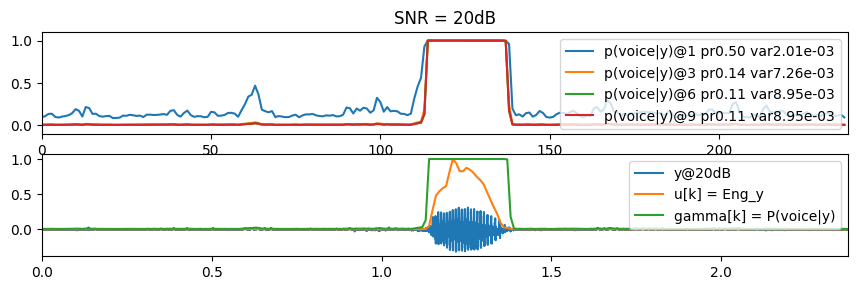

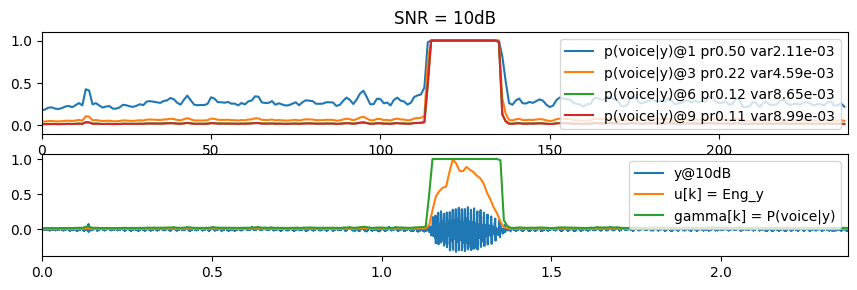

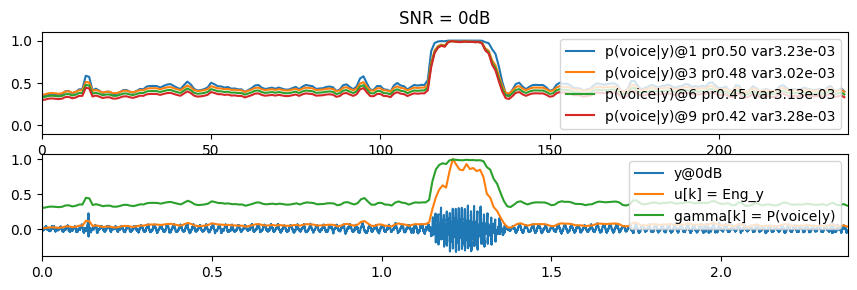

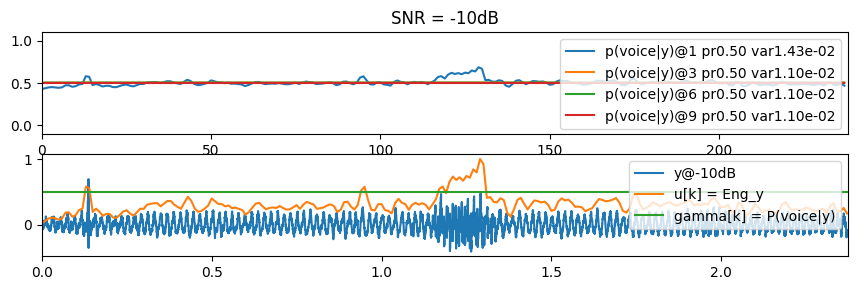

In [24]:
for ii in range(len(mixedSig1)):
    doexp_vad_time(mixedSig1[ii], mixsnrs[ii], 9, 3, True)

37920 32
Var(N), Pr(N) = 0.0000, 0.50  Var(X), Pr(X) = 0.0020, 0.50
Epoch 1: Var(N),Var(X) = (0.001, 0.113)x1.782e-02  Pr(N),Pr(X) = (0.50, 0.50)
Epoch 3: Var(N),Var(X) = (0.001, 0.407)x1.782e-02  Pr(N),Pr(X) = (0.86, 0.14)
Epoch 6: Var(N),Var(X) = (0.001, 0.502)x1.782e-02  Pr(N),Pr(X) = (0.89, 0.11)
Epoch 9: Var(N),Var(X) = (0.001, 0.502)x1.782e-02  Pr(N),Pr(X) = (0.89, 0.11)
Var(N), Pr(N) = 0.0000, 0.50  Var(X), Pr(X) = 0.0020, 0.50
Epoch 1: Var(N),Var(X) = (0.001, 0.113)x1.782e-02  Pr(N),Pr(X) = (0.50, 0.50)
Epoch 3: Var(N),Var(X) = (0.001, 0.407)x1.782e-02  Pr(N),Pr(X) = (0.86, 0.14)
Epoch 6: Var(N),Var(X) = (0.001, 0.502)x1.782e-02  Pr(N),Pr(X) = (0.89, 0.11)
Epoch 9: Var(N),Var(X) = (0.001, 0.502)x1.782e-02  Pr(N),Pr(X) = (0.89, 0.11)
37920 32
Var(N), Pr(N) = 0.0001, 0.50  Var(X), Pr(X) = 0.0021, 0.50
Epoch 1: Var(N),Var(X) = (0.005, 0.118)x1.795e-02  Pr(N),Pr(X) = (0.50, 0.50)
Epoch 3: Var(N),Var(X) = (0.006, 0.256)x1.795e-02  Pr(N),Pr(X) = (0.78, 0.22)
Epoch 6: Var(N),Var(X) = 

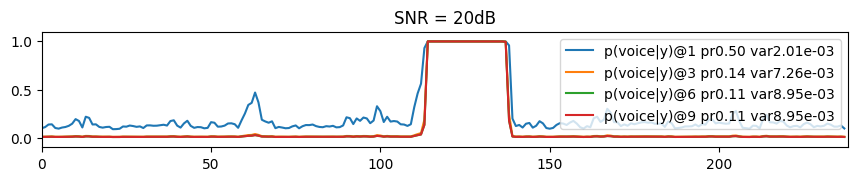

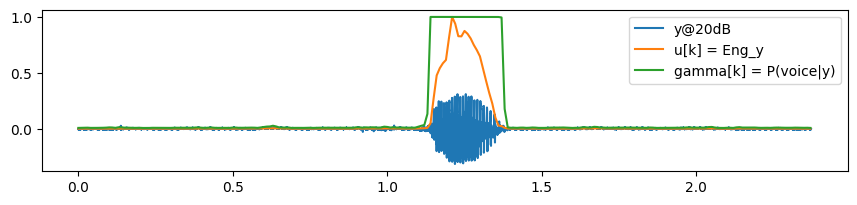

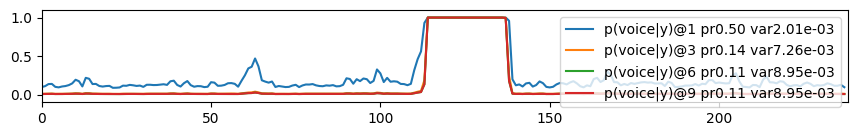

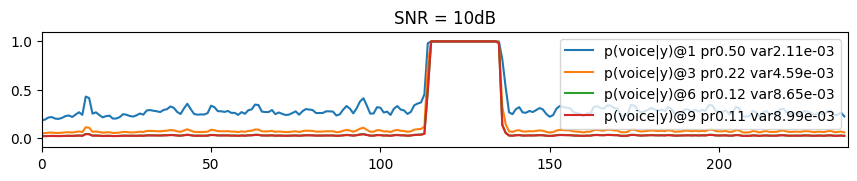

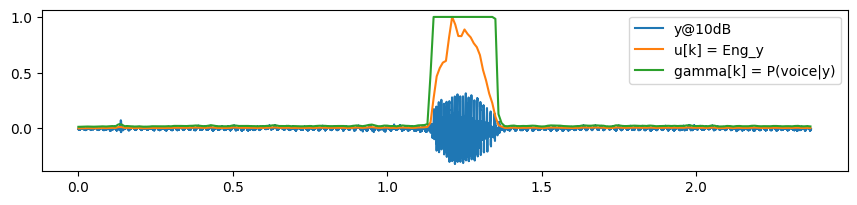

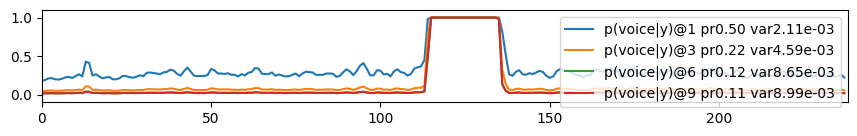

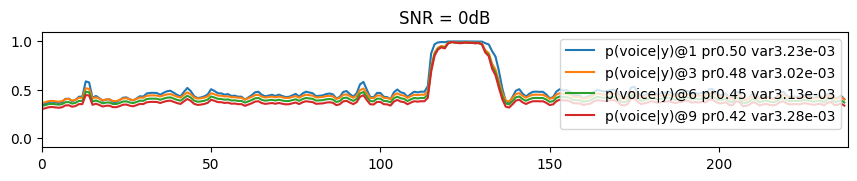

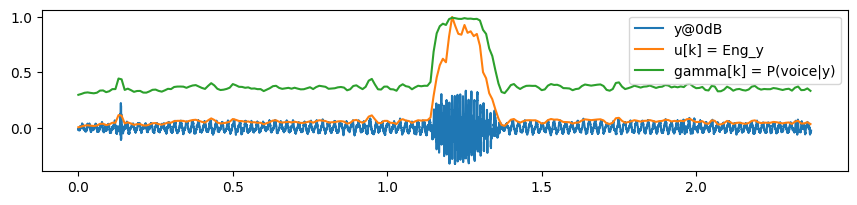

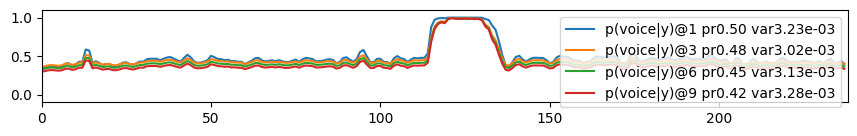

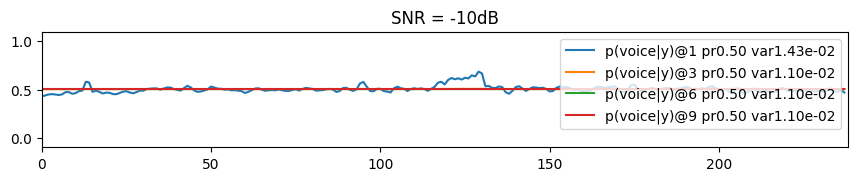

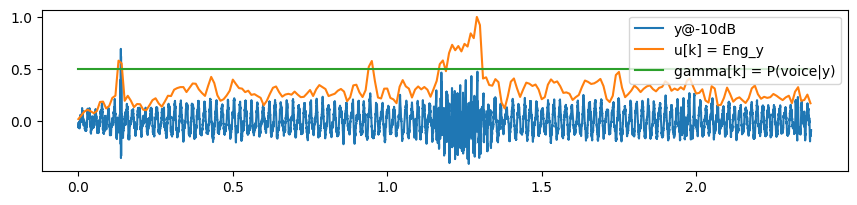

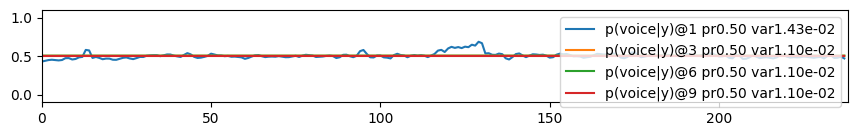

In [25]:
gmm = dualGMMVAD_time_sq()
gmm.set_dispstep(3)
epoch = 9

for ii in range(len(mixedSig1)):
    mix = mixedSig1[ii]
    umix, Iu = ShortTimeFrameEng(mix, Nf, Ns)

    plt.figure(figsize=FIG_SIZE*np.array([1.3,0.5]))
    gmm.set_initial_params(umix)
    gamma = gmm.train_batch(umix, epoch, False)
    plt.legend(loc='upper right')
    plt.title('SNR = %.0fdB'%(mixsnrs[ii]))
    
    plt.figure(figsize=FIG_SIZE*np.array([1.3,0.7]))
    plt.plot(np.arange(1,len(mix)+1)/Fs,mix,label='y@%.0fdB'%(mixsnrs[ii]))
    plt.plot(Iu/Fs,umix/max(umix),label='u[k] = Eng_y')
    plt.plot(Iu/Fs,gamma,label='gamma[k] = P(voice|y)')
    plt.legend(loc='upper right')

    plt.figure(figsize=FIG_SIZE*np.array([1.3,0.4]))
    gmm.set_initial_params(umix)
    gamma = gmm.train_batch(umix, epoch, True)
    plt.legend(loc='upper right')

37920 32
37920 32
37920 32
37920 32


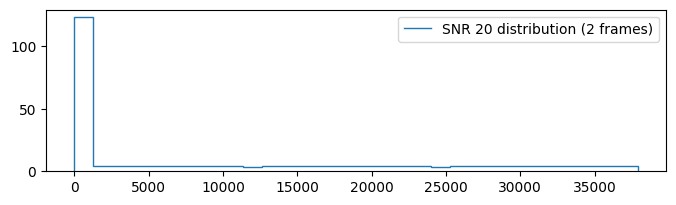

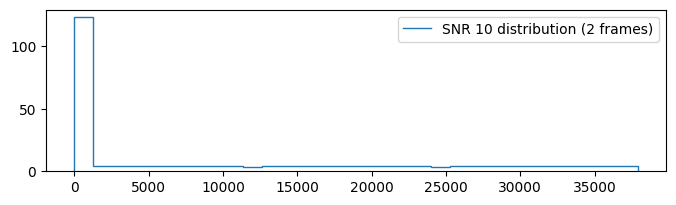

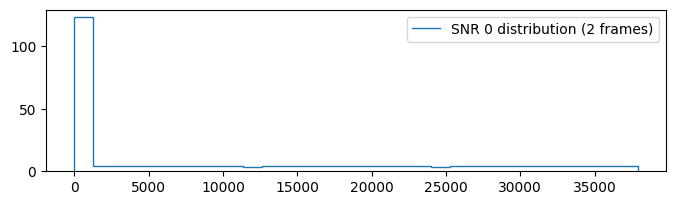

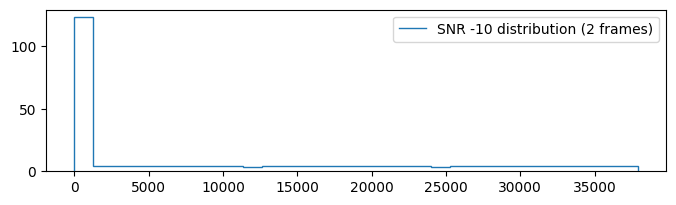

In [26]:
for ii in range(len(mixedSig1)):
    mix = mixedSig1[ii]
    
    umix = ShortTimeFrameEng(mix, Nf, Ns)
    
    
    
    ####################################가정
    # plot
    plt.figure(figsize=FIG_SIZE*np.array([1.0,0.7]))
    plot_relative_hist(umix, bins=30, lab='SNR %.0f distribution (%d frames)'%(mixsnrs[ii],len(umix)))
    plt.legend(loc='upper right')



In [27]:
####################################
def __sumSpect(x, I):
    #plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
    #plt.plot(x[I[0]:I[1]])
    Nt = I[1]-I[0]
    nframes = int((Nt-Nf)//Ns+1)
    Sxx = np.zeros(hNo)   # E[N*conj(N)]
    for n in range(nframes):
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT)
        aX2 = (X*np.conj(X))
        Sxx += aX2[:hNo].real
        
    return Sxx, nframes

####################################
def estSpect(x, IntervalMulti=[]):
    # x: 1-dim time domain signal
    # IntervalMulti:  
    #   2-dim matrix, [n_interval, 2]: multiple intervals
    #   empty list: use all x
    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0, len(x)]])
    #print(IntervalMulti, IntervalMulti.shape)
    
    # accumulate interval power spectral densities
    SxxSum = np.zeros(hNo)   # E[N*conj(N)]
    NumFrames = 0
    for ii in range(IntervalMulti.shape[0]):
        [Sxx, N] = __sumSpect(x, IntervalMulti[ii,:].astype(int))
        SxxSum = SxxSum + Sxx
        NumFrames += N
        
    # average (E[x*conj(x)]
    return SxxSum/NumFrames

In [28]:
####################################
mix = mixedSig[1]
SyyAll = estSpect(mix, [])
#SyyEPD = estSpect(mix, np.array([[1.1, 1.4]])*Fs)
#SxxEPD = estSpect(speech, np.array([[1.1, 1.4]])*Fs)
SnnHead = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
SnnEPD = estSpect(mix, np.array([[0,1.0], [1.5, 2.0], [2.0, 2.2]])*Fs)

####################################
# plot
plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
xticks=np.linspace(0, 1, num=hNo, endpoint=True)

plt.subplot(1,2,1)
plt.plot(xticks,SyyAll,label='$|X(\omega)|^2$')
plt.plot(xticks,SnnHead,label='$|N_{0.5}(\omega)|^2$')
plt.plot(xticks,SnnEPD,label='$|N_{non-speech}(\omega)|^2$')
#plt.plot(xticks,SxxEPD,label='$|S(\omega)|^2$')
plt.title('$|N(\omega)|^2$ ($S_{nn}$) estimates')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.plot(xticks,np.log(SyyAll),label='$|\log X(\omega)|^2$')
plt.plot(xticks,np.log(SnnHead),label='$|\log N_{0.5}(\omega)|^2$')
plt.plot(xticks,np.log(SnnEPD),label='$|\log N_{non-speech}(\omega)|^2$')
#plt.plot(xticks,np.log(SxxEPD),label='$|\log S(\omega)|^2$')
plt.title('$|\log N(\omega)|^2$ estimates')
plt.legend(loc='upper right')

NameError: name 'mixedSig' is not defined

- 0.5초로 추정한 $|N(\omega)|^2$ 이 전체 non-speech 구간에 매우 유사함을 알 수 있다.
- Wiener filter 를 time domain FIR filter 로 구하고 적용한다. 
  아래 코드는 online processing 을 염두에 두고 한 shift (10ms) 처리하는 방식으로 구현되었다.
- plot Wiener filters

In [ ]:
order = 30
noverlap = int(Fs*0.003)   # 3ms
Nx = len(mix)

#minwfgain = 10**(-13/20)    # 0.228
minwfgain = 10**(-20/20)    # 0.1

fola = firoverlapadd()
fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)

# overlap add 를 할 때는 10ms 씩 shift 해야 한다.
xbuf = np.zeros(Nf)
speechest = []
for mix in mixedSig:
    Snn = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
    
    Tx = len(mix)
    yout = np.zeros(Nx+fola.getDelay())
    Lout = 0
    xbuf[:] = 0
    t = 0  # time index
    H_a = np.zeros((hNo,0))   # for drawing
    while True:
        t1 = min(t,Nx)      # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
        t2 = min(t+Ns,Nx)   # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함
        
        for ii in range(Nf-Ns):
            xbuf[ii] = xbuf[ii+Ns]
        xbuf[(Nf-Ns):] = 0
        for ii in range(t2-t1):
            xbuf[(Nf-Ns)+ii] = mix[t1+ii]
        X = np.fft.fft(xbuf, NFFT)
        aX2 = (X*np.conj(X))
        Syy = aX2[:hNo].real
        Syy = np.maximum(1e-100, Syy)  # to prevent divide by zero
        H = (Syy-Snn)/Syy
        H = np.maximum(minwfgain, H)
        '''
        if t<Ns*10:
            plt.figure(figsize=FIG_SIZE*np.array([1.2,0.9]))
            #plt.plot(H)
            plt.plot(Syy)
            plt.plot(Snn)
            plt.plot(Syy-Snn)
        '''
        H_a = np.column_stack([H_a, np.expand_dims(H,axis=1)])

        h, _ = getLPHFIRFFT(H, order, winname='hamming')
        x = mix[t1:t2]
        y, l = fola.doFilterMem(h,x)
        if l > len(yout)-Lout:
            print(len(yout), Lout, len(yout)-Lout, Lout, l)
            l = len(yout)-Lout            
        if l <= 0: break
        
        yout[Lout:(Lout+l)] = y[:l]
        Lout += l
        t += Ns
        
    speechest.append(yout)
    plt.figure(figsize=FIG_SIZE*np.array([1.0,0.5]))
    plt.imshow(H_a, cmap=cmap_plot, aspect='auto', origin='lower')    

- save noise suppresion results in files
- compare before and after by SNR
    > linear phase Wiener filter with overlap-add 를 하면 order + overlap 만큼의 delay 가 발생한다. 
    > noise suppressed signal 을 shift 하여 SNR 을 계산한다.

In [ ]:
def getsnr(target, est):
    diff = np.sum((target-est)**2)
    diff = max(diff, 1e-30)   # to prevent divide by zero
    return 10*(np.log10(np.sum(target**2))-np.log10(diff))

nsWavfiles = []
for m in range(len(mixedSig)):
    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.2]))
    plt.subplot(2,2,1)
    plt.plot(mixedSig[m])
    #plt.title('SNR = %.2f -> .2f dB' % (mixsnrs[m]))
    snrmix = getsnr(speech, mixedSig[m])
    snrest = getsnr(speech, speechest[m][fola.getDelay():])
    plt.title('SNR = %.2f -> %.2f dB' % (snrmix, snrest))
    plt.subplot(2,2,2)
    drawspectrogram3(mixedSig[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    plt.subplot(2,2,3)
    plt.plot(speechest[m])
    plt.subplot(2,2,4)
    drawspectrogram3(speechest[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    
    # save the noise suppressed audio file
    fname = addpath(outpath, 'ns%.fdb.wav' % (mixsnrs[m]))
    wav.writewav(fname, Fs, speechest[m], maxval=1.0)
    nsWavfiles.append(fname)

- SNR imporvement 가 만족스럽진 않다. 이 예제가 저음이 강해서 대부분 잡음이 영향을 많이 주진 못한다.
- -10 dB 의 경우 음성의 왜곡이 많이 발생한다.
- mixed sound 와 noise suppressed sound 를 들어보자

In [ ]:
IPython.display.Audio(mixedWavfiles[0])

In [ ]:
IPython.display.Audio(nsWavfiles[0])

In [ ]:
IPython.display.Audio(mixedWavfiles[1])

In [ ]:
IPython.display.Audio(nsWavfiles[1])

In [ ]:
IPython.display.Audio(mixedWavfiles[2])

In [ ]:
IPython.display.Audio(nsWavfiles[2])

In [ ]:
IPython.display.Audio(mixedWavfiles[3])

In [ ]:
IPython.display.Audio(nsWavfiles[3])

.

### Noise spectrum estimation with EPD (end point detection)
1. noise 는 stationary, speech 는 non-stationary 가정
2. 처음 일정 시간은 noise 만 있다고 가정하고 이 구간의 평균 spectral energy ($|\cdot|^2$) 을 추정
    - 아래 예제는 $0 \sim 0.5$ sec

.

## End of Lab 05